# Práctica Calificada 1 - Grupo 2: Comparación de Modelos

**Objetivo:** Este notebook consolida los tres modelos desarrollados (SARIMA, XGBoost, LSTM), los re-entrena y compara sus resultados para seleccionar el mejor modelo para la predicción de demanda.

## 1. Carga de Librerías y Datos

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 8)

print("Librerías cargadas exitosamente.")

Librerías cargadas exitosamente.


### 1.1. Preparación de Datos

Cargamos los datos y preparamos la serie de tiempo para el producto con mayores ingresos.

In [2]:
project_root = Path().resolve().parents[0]
PROCESSED_DATA_PATH = project_root / 'data' / 'processed' / 'group2_data.parquet'
df = pd.read_parquet(PROCESSED_DATA_PATH)
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
top_product_sku = df.groupby('product_sku')["total_product_revenue_usd"].sum().nlargest(1).index[0]
ts_one_product = df[df["product_sku"] == top_product_sku].copy()
ts_one_product.set_index('transaction_date', inplace=True)
ts_one_product = ts_one_product.asfreq('D').fillna(0)
target_col = 'total_product_quantity'
ts = ts_one_product[target_col]
print(f"Datos preparados para el producto: {top_product_sku}")

Datos preparados para el producto: GGOEGDHQ015399


## 2. Ejecución, Evaluación y Comparación de Modelos

A continuación, re-entrenamos cada modelo, guardamos sus predicciones y métricas, y visualizamos los resultados.

--- Entrenando SARIMA ---
SARIMA entrenado.
--- Entrenando XGBoost ---
XGBoost entrenado.
--- Entrenando LSTM ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
LSTM entrenado.
Tabla Comparativa de Métricas (MAE y RMSE):


,MAE,RMSE
XGBoost,5.835883,6.385823
SARIMA,5.745101,7.143839
LSTM,7.152415,8.360656


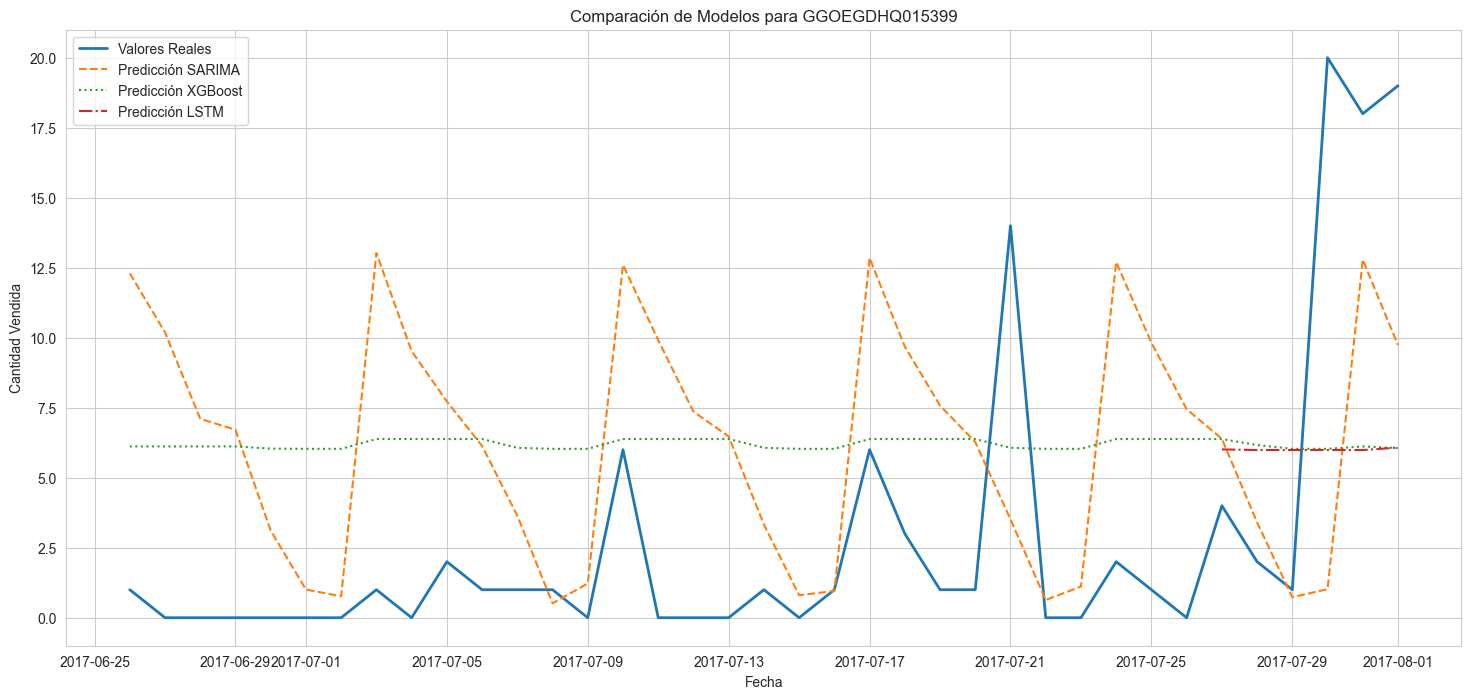

In [3]:
# -- División de Datos Común --
train_size = int(len(ts) * 0.9)
train, test = ts[0:train_size], ts[train_size:]

results = {}
predictions = {'real': test}

# -- Modelo 1: SARIMA --
print("--- Entrenando SARIMA ---")
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]
best_aic = float("inf")
best_model_sarima = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_model_sarima = res
        except:
            continue
pred_sarima = best_model_sarima.get_prediction(start=test.index[0], end=test.index[-1])
predictions['SARIMA'] = pred_sarima.predicted_mean
results['SARIMA'] = {'MAE': mean_absolute_error(test, pred_sarima.predicted_mean), 'RMSE': np.sqrt(mean_squared_error(test, pred_sarima.predicted_mean))}
print("SARIMA entrenado.")

# -- Modelo 2: XGBoost --
print("--- Entrenando XGBoost ---")
def create_features(df, target_col):
    df_feat = df.to_frame().copy()
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['dayofyear'] = df_feat.index.dayofyear
    for lag in [1, 7, 14]: df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
    for win in [7, 14]: df_feat[f'roll_mean_{win}'] = df_feat[target_col].shift(1).rolling(window=win).mean()
    df_feat.dropna(inplace=True)
    return df_feat
df_featured = create_features(ts, target_col)
X = df_featured.drop(columns=[target_col])
y = df_featured[target_col]
split_date = test.index[0]
X_train, X_test = X[X.index < split_date], X[X.index >= split_date]
y_train, y_test = y[y.index < split_date], y[y.index >= split_date]
reg = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, eval_metric='rmse', learning_rate=0.01, random_state=42)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
pred_xgb = reg.predict(X_test)
predictions['XGBoost'] = pd.Series(pred_xgb, index=y_test.index)
results['XGBoost'] = {'MAE': mean_absolute_error(y_test, pred_xgb), 'RMSE': np.sqrt(mean_squared_error(y_test, pred_xgb))}
print("XGBoost entrenado.")

# -- Modelo 3: LSTM --
print("--- Entrenando LSTM ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts.to_frame())
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:, :]
def create_sequences(dataset, look_back=30):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1): X.append(dataset[i:(i + look_back), 0]); Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
look_back = 30
X_train_lstm, y_train_lstm = create_sequences(train_data, look_back)
X_test_lstm, y_test_lstm = create_sequences(test_data, look_back)
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
model_lstm = Sequential([LSTM(50, return_sequences=True, input_shape=(look_back, 1)), Dropout(0.2), LSTM(50), Dropout(0.2), Dense(25), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=50, validation_split=0.1, callbacks=[EarlyStopping(patience=10)], verbose=0)
pred_lstm_scaled = model_lstm.predict(X_test_lstm)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)
y_test_lstm_inv = scaler.inverse_transform([y_test_lstm])
lstm_pred_index = ts.index[len(train_data) + look_back + 1 : len(train_data) + look_back + 1 + len(pred_lstm)]
predictions['LSTM'] = pd.Series(pred_lstm.flatten(), index=lstm_pred_index)
results['LSTM'] = {'MAE': mean_absolute_error(y_test_lstm_inv[0], pred_lstm.flatten()), 'RMSE': np.sqrt(mean_squared_error(y_test_lstm_inv[0], pred_lstm.flatten()))}
print("LSTM entrenado.")

# --- Comparación de Resultados ---
# Crear DataFrame con los resultados
df_results = pd.DataFrame(results).T
print("Tabla Comparativa de Métricas (MAE y RMSE):")
display(df_results.sort_values('RMSE'))

# Crear DataFrame con todas las predicciones
df_preds = pd.DataFrame(predictions)
# El índice de las predicciones de ML y LSTM puede no coincidir exactamente con el de test
# por la creación de lags/secuencias. Se ajustan al índice de test para graficar.
df_preds.index = test.index[:len(df_preds)]

# Visualizar todas las predicciones
plt.figure(figsize=(18, 8))
plt.plot(df_preds['real'], label='Valores Reales', linewidth=2)
plt.plot(df_preds['SARIMA'], label='Predicción SARIMA', linestyle='--')
plt.plot(df_preds['XGBoost'], label='Predicción XGBoost', linestyle=':')
plt.plot(df_preds['LSTM'], label='Predicción LSTM', linestyle='-.')
plt.title(f'Comparación de Modelos para {top_product_sku}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.show()